In [289]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings('ignore')
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
kn = KNeighborsRegressor()
from sklearn.metrics import r2_score

In [290]:
dtest = pd.read_excel('D:/ds/Test_set.xlsx')
dtrain = pd.read_excel('D:/ds/Data_Train.xlsx')

In [291]:
df = pd.concat([dtest.assign(ind="test"), dtrain.assign(ind="train")])

In [292]:
df = df.drop('ind', axis = 1)
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,NaN
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,NaN
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,NaN
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,NaN
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,NaN
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107.0
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145.0
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229.0
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648.0


Dataset is 13354 rows × 12 columns. The price is to be predicted because of which there is NA in it.

In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13354 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Date_of_Journey  13354 non-null  object 
 2   Source           13354 non-null  object 
 3   Destination      13354 non-null  object 
 4   Route            13353 non-null  object 
 5   Dep_Time         13354 non-null  object 
 6   Arrival_Time     13354 non-null  object 
 7   Duration         13354 non-null  object 
 8   Total_Stops      13353 non-null  object 
 9   Additional_Info  13354 non-null  object 
 10  Price            10683 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.2+ MB


There needs to be coding done on factors. Price has missing data which needs to be predicted. Date needs to be split into year, month, day as they impact the prices. Departure and arrival times need to be treated too

In [294]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], dayfirst=True)
df['year'],df['month'],df['day'] = df.Date_of_Journey.dt.year, df.Date_of_Journey.dt.month, df.Date_of_Journey.dt.day
df['Arrival_Time'] = df['Arrival_Time'].str[:5]
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day
0,Jet Airways,2019-06-06,Delhi,Cochin,DEL → BOM → COK,17:30,04:25,10h 55m,1 stop,No info,NaN,2019,6,6
1,IndiGo,2019-05-12,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,NaN,2019,5,12
2,Jet Airways,2019-05-21,Delhi,Cochin,DEL → BOM → COK,19:15,19:00,23h 45m,1 stop,In-flight meal not included,NaN,2019,5,21
3,Multiple carriers,2019-05-21,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,NaN,2019,5,21
4,Air Asia,2019-06-24,Banglore,Delhi,BLR → DEL,23:55,02:45,2h 50m,non-stop,No info,NaN,2019,6,24


In [295]:
df['Duration']=  df['Duration'].str.replace("h", '*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
df['Duration']

0         655
1         240
2        1425
3         780
4         170
         ... 
10678     150
10679     155
10680     180
10681     160
10682     500
Name: Duration, Length: 13354, dtype: int64

In [296]:
df.isnull().sum()

Airline               0
Date_of_Journey       0
Source                0
Destination           0
Route                 1
Dep_Time              0
Arrival_Time          0
Duration              0
Total_Stops           1
Additional_Info       0
Price              2671
year                  0
month                 0
day                   0
dtype: int64

We need to fill in null data as per different imputational techniques, post looking at the correlation

In [300]:
#Checking for null values in each and filling with apt data
df[df['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day
9039,Air India,2019-05-06,Delhi,Cochin,NaN,09:45,09:25,1420,NaN,No info,7480.0,2019,5,6


In [301]:
#Both null values are in the same row. Using apt imputation technique to fill the data. 
df['Route'].value_counts()

DEL → BOM → COK          3000
BLR → DEL                1941
CCU → BOM → BLR          1232
CCU → BLR                 896
BOM → HYD                 785
                         ... 
BOM → CCU → HYD             1
BOM → VNS → DEL → HYD       1
BOM → BBI → HYD             1
BOM → UDR → DEL → HYD       1
BOM → IXC → DEL → HYD       1
Name: Route, Length: 132, dtype: int64

In [302]:
#delhi bombay cockin is the most popular route. We'll fill same data in missing values
df['Total_Stops']=df['Total_Stops'].fillna('1 stop')
df['Route']=df['Route'].fillna('DEL → BOM → COK')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13354 entries, 0 to 10682
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          13354 non-null  object        
 1   Date_of_Journey  13354 non-null  datetime64[ns]
 2   Source           13354 non-null  object        
 3   Destination      13354 non-null  object        
 4   Route            13354 non-null  object        
 5   Dep_Time         13354 non-null  object        
 6   Arrival_Time     13354 non-null  object        
 7   Duration         13354 non-null  int64         
 8   Total_Stops      13354 non-null  object        
 9   Additional_Info  13354 non-null  object        
 10  Price            10683 non-null  float64       
 11  year             13354 non-null  int64         
 12  month            13354 non-null  int64         
 13  day              13354 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int6

In [304]:
#Splitting route into different sections for better price understanding ad the greater the route, greater the cost
df['Route_1']=df['Route'].str.split('→ ').str[0]
df['Route_2']=df['Route'].str.split('→ ').str[1]
df['Route_3']=df['Route'].str.split('→ ').str[2]
df['Route_4']=df['Route'].str.split('→ ').str[3]
df['Route_5']=df['Route'].str.split('→ ').str[4]
df['Route_1'].fillna("None",inplace=True)
df['Route_2'].fillna("None",inplace=True)
df['Route_3'].fillna("None",inplace=True)
df['Route_4'].fillna("None",inplace=True)
df['Route_5'].fillna("None",inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13354 entries, 0 to 10682
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          13354 non-null  object        
 1   Date_of_Journey  13354 non-null  datetime64[ns]
 2   Source           13354 non-null  object        
 3   Destination      13354 non-null  object        
 4   Route            13354 non-null  object        
 5   Dep_Time         13354 non-null  object        
 6   Arrival_Time     13354 non-null  object        
 7   Duration         13354 non-null  int64         
 8   Total_Stops      13354 non-null  object        
 9   Additional_Info  13354 non-null  object        
 10  Price            10683 non-null  float64       
 11  year             13354 non-null  int64         
 12  month            13354 non-null  int64         
 13  day              13354 non-null  int64         
 14  Route_1          13354 non-null  objec

In [305]:
df['year'].value_counts()

2019    13354
Name: year, dtype: int64

Removing year as it does not add to anything. Removing Date of joutney as well.

In [306]:
df = df.drop(['Date_of_Journey','year'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13354 entries, 0 to 10682
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Source           13354 non-null  object 
 2   Destination      13354 non-null  object 
 3   Route            13354 non-null  object 
 4   Dep_Time         13354 non-null  object 
 5   Arrival_Time     13354 non-null  object 
 6   Duration         13354 non-null  int64  
 7   Total_Stops      13354 non-null  object 
 8   Additional_Info  13354 non-null  object 
 9   Price            10683 non-null  float64
 10  month            13354 non-null  int64  
 11  day              13354 non-null  int64  
 12  Route_1          13354 non-null  object 
 13  Route_2          13354 non-null  object 
 14  Route_3          13354 non-null  object 
 15  Route_4          13354 non-null  object 
 16  Route_5          13354 non-null  object 
dtypes: float64(1

In [307]:
from sklearn.preprocessing import LabelEncoder
lenc = LabelEncoder()
for i in df:
    if df[i].dtypes == 'object':
        s1 = lenc.fit_transform(df[i])
        s1 = pd.DataFrame(s1)
        df[i] = s1
    else:
        continue
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13354 entries, 0 to 10682
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  int32  
 1   Source           13354 non-null  int32  
 2   Destination      13354 non-null  int32  
 3   Route            13354 non-null  int32  
 4   Dep_Time         13354 non-null  int32  
 5   Arrival_Time     13354 non-null  int32  
 6   Duration         13354 non-null  int64  
 7   Total_Stops      13354 non-null  int32  
 8   Additional_Info  13354 non-null  int32  
 9   Price            10683 non-null  float64
 10  month            13354 non-null  int64  
 11  day              13354 non-null  int64  
 12  Route_1          13354 non-null  int32  
 13  Route_2          13354 non-null  int32  
 14  Route_3          13354 non-null  int32  
 15  Route_4          13354 non-null  int32  
 16  Route_5          13354 non-null  int32  
dtypes: float64(1

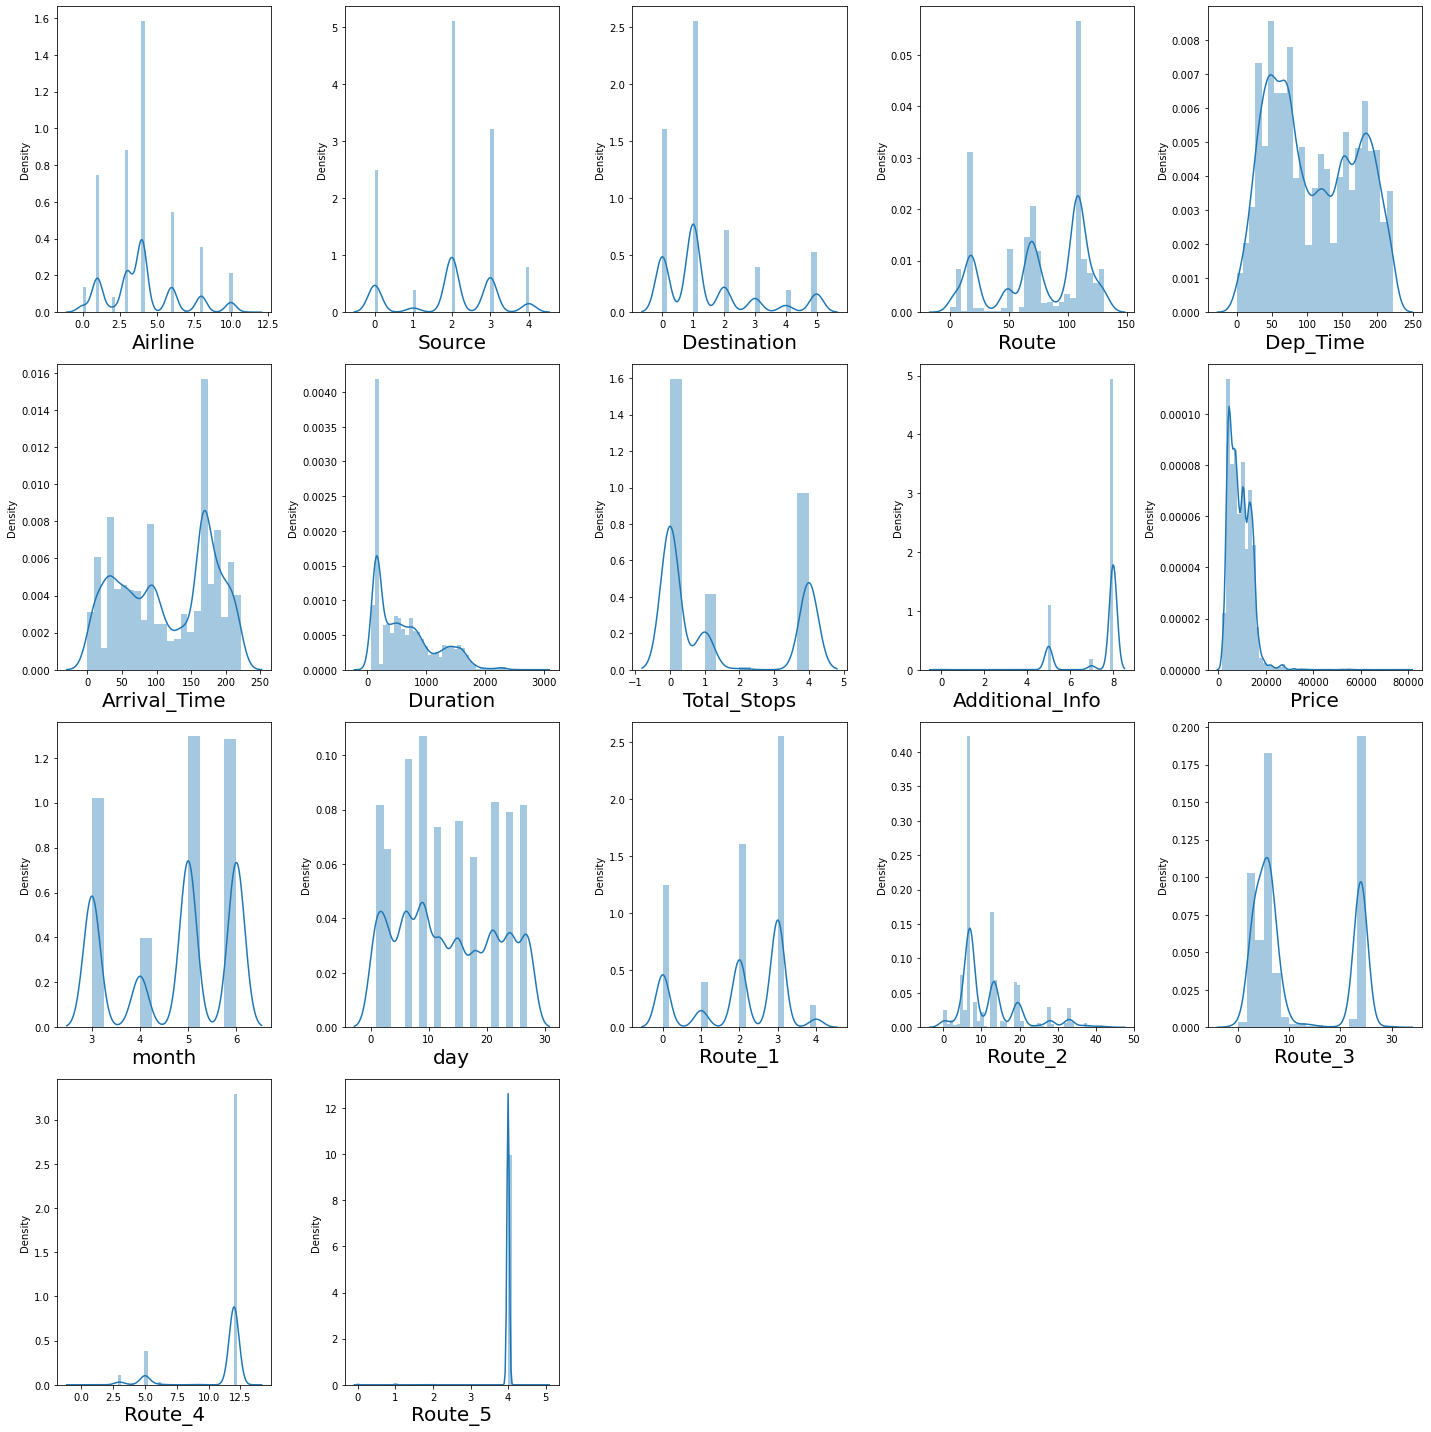

In [310]:
plt.figure(figsize=(20,20))
pltn = 1
for c in df:
    ax= plt.subplot(4,5,pltn)
    sns.distplot(df[c])  
    plt.xlabel(c,fontsize=20)
    pltn+=1
plt.tight_layout()

In [311]:
df.skew()

Airline             0.714014
Source             -0.423636
Destination         1.256580
Route              -0.518854
Dep_Time            0.198149
Arrival_Time       -0.136501
Duration            0.867883
Total_Stops         0.648457
Additional_Info    -1.822650
Price               1.812552
month              -0.390684
day                 0.135142
Route_1            -0.617710
Route_2             1.442389
Route_3             0.599586
Route_4            -2.140000
Route_5           -16.018252
dtype: float64

Duration is the only skewed data. Fixing the skew with z score. 

In [319]:
from scipy.stats import zscore
z=np.abs(zscore(df[['Duration']]))
dfn=df[(z<2).all(axis=1)]
dfn.shape

(12908, 17)

In [321]:
#Less than 5 % of data is lost. it is ok.
dfn.skew()

Airline             0.710250
Source             -0.420899
Destination         1.254322
Route              -0.518455
Dep_Time            0.201232
Arrival_Time       -0.130827
Duration            0.744500
Total_Stops         0.641084
Additional_Info    -1.799103
Price               1.894976
month              -0.403844
day                 0.134430
Route_1            -0.616983
Route_2             1.445479
Route_3             0.593719
Route_4            -2.193089
Route_5           -16.475763
dtype: float64

In [327]:
#Applying yeo - johnson to fix skew
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method='yeo-johnson', standardize=True)
dfn1 = power.fit_transform(dfn[['Duration']])
dfn1 = pd.DataFrame(dfn1)
dfn1.columns = dfn[['Duration']].columns
dfn.index = dfn1.index
for i in dfn1:
    dfn[i] = dfn1[i]
    
dfn.skew()

Airline             0.710250
Source             -0.420899
Destination         1.254322
Route              -0.518455
Dep_Time            0.201232
Arrival_Time       -0.130827
Duration           -0.000596
Total_Stops         0.641084
Additional_Info    -1.799103
Price               1.894976
month              -0.403844
day                 0.134430
Route_1            -0.616983
Route_2             1.445479
Route_3             0.593719
Route_4            -2.193089
Route_5           -16.475763
dtype: float64

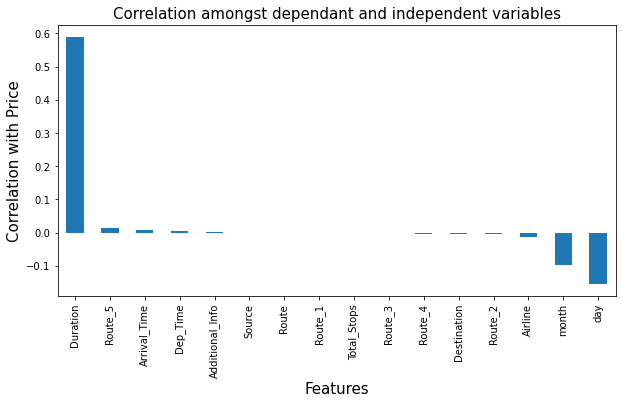

In [328]:
df2 = dfn.corr()
plt.figure(figsize=(10,5))
df2['Price'].sort_values(ascending=False).drop(['Price']).plot(kind='bar')
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Correlation with Price', fontsize = 15)
plt.title('Correlation amongst dependant and independent variables', fontsize = 15)
plt.show()

In [330]:
#We will look at duration as a factor to fit nan values of price.
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
itim = IterativeImputer()
dfn['Price'] = itim.fit_transform(dfn[['Duration', 'Price']])[:,1]
dfn.isnull().sum()

Airline            0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
month              0
day                0
Route_1            0
Route_2            0
Route_3            0
Route_4            0
Route_5            0
dtype: int64

In [335]:
x = dfn.drop(['Price', 'Route'], axis = 1)
y = dfn['Price']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 4)

In [336]:
lr.fit(x_train, y_train)
dt.fit(x_train, y_train)
kn.fit(x_train, y_train)
rf.fit(x_train, y_train)
print(lr.score(x_test, y_test), dt.score(x_test, y_test), kn.score(x_test, y_test), rf.score(x_test, y_test))

0.3998278292197056 0.33851519252455775 -0.047297536075090685 0.6176561677013558


In [337]:
#Model is very low on accuracy. We should work on the data more.
from sklearn.feature_selection import SelectKBest, f_classif
bf= SelectKBest(score_func = f_classif, k='all')
fit = bf.fit(x,y)
df_scores=pd.DataFrame(fit.scores_)
df_columns=pd.DataFrame(x.columns)

#concatenate dataframes
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature name', 'Score']
print(feature_scores.nlargest(15,'Score'))

       Feature name      Score
5          Duration  50.563665
8             month  10.764257
9               day   2.635971
6       Total_Stops   2.615993
12          Route_3   2.558149
1            Source   2.063283
10          Route_1   2.032045
13          Route_4   1.819784
11          Route_2   1.679197
2       Destination   1.611099
14          Route_5   1.518446
3          Dep_Time   1.326891
4      Arrival_Time   1.307590
0           Airline   1.303391
7   Additional_Info   1.173300


In [338]:
# There is information only in higher Kscores. Rest all can be removed. Looking at multicollinearity
vif1 = pd.DataFrame()
Xsc = np.asarray(x)
vif1['score'] = [variance_inflation_factor(Xsc,i) for i in range (Xsc.shape[1])]
vif1['Feature'] = x.columns
vif1

,score,Feature
0,4.223876,Airline
1,6.122714,Source
2,3.752506,Destination
3,4.361537,Dep_Time
4,4.079957,Arrival_Time
5,1.033541,Duration
6,22.325026,Total_Stops
7,40.084140,Additional_Info
8,17.119651,month
9,3.492678,day


<AxesSubplot:>

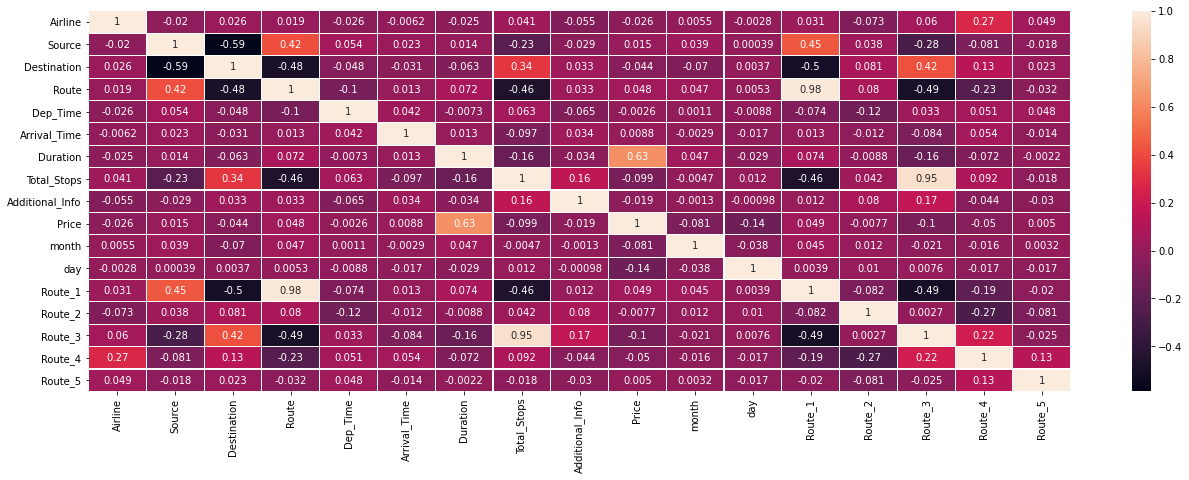

In [339]:
plt.figure(figsize=(22,7))
sns.heatmap(dfn.corr(), annot=True, linewidths=0.1)

In [341]:
x = x.drop(['Additional_Info', 'Airline', 'Arrival_Time', 'Dep_Time', 'Route_5'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 4)
lr.fit(x_train, y_train)
dt.fit(x_train, y_train)
kn.fit(x_train, y_train)
rf.fit(x_train, y_train)
print(lr.score(x_test, y_test), dt.score(x_test, y_test), kn.score(x_test, y_test), rf.score(x_test, y_test))

0.399966080330719 0.3479863577539166 0.4213957208800715 0.622027343159085


In [343]:
x = x.drop(['Destination', 'Route_2', 'Route_4'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.25, random_state = 4)
lr.fit(x_train, y_train)
dt.fit(x_train, y_train)
kn.fit(x_train, y_train)
rf.fit(x_train, y_train)
print(lr.score(x_test, y_test), dt.score(x_test, y_test), kn.score(x_test, y_test), rf.score(x_test, y_test))

0.40009021201318073 0.41361122334088274 0.522867706863894 0.616218492286208


In [351]:
#60% accuracy is reached. Performing CV on random forest
from sklearn.model_selection import GridSearchCV
params = {'bootstrap': [True, False],
          'n_estimators': [100, 150, 200],
          'max_depth': [13, 15, 17],
         'min_samples_split': [5, 10],
         'min_samples_leaf': [5, 10]}
grd = GridSearchCV(rf, param_grid = params)
grd.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False], 'max_depth': [13, 15, 17],
                         'min_samples_leaf': [5, 10],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 150, 200]})

In [352]:
rfc = grd.best_estimator_
rfc.fit(x_train, y_train)
rfc.score(x_test,y_test)

0.6367665937821712

In [353]:
#There is no overfitting of the model. The accuracy is not increasing much. Saving the model.
import joblib
joblib.dump(rfc, 'Flightrate.pkl')

['Flightrate.pkl']